# Model Training
Welcome to the 'Model Training and Prediction' notebook, a crucial facet of our project's data science pipeline. In this notebook, we offer a meticulous examination of our rigorous model development process. The pipeline starts by accepting training data, followed by fitting three distinct types of models to it: Random Forest, Gradient Boosted Tree, and XGBoost. The initial stages include encoding categorical variables and executing Recursive Feature Elimination (RFE) for feature selection. This is succeeded by the application of genetic algorithms to hyperparameter tuning, operating in tandem with a cross-validation routine. Subsequently, the best model is selected based on the highest F1 score, indicating the balance between precision and recall. Finally, the selected model is utilized to predict the outcomes for the current week's round of NRL matches. This process is iterative and cyclical, with the potential for revisiting earlier stages based on the model's performance. Let us proceed with this in-depth exploration.

## Set up Environment
This code segment is setting up the environment for the model training pipeline. It begins by importing sys and pathlib - Python libraries used for managing system parameters and file paths, respectively.

The code then updates the system path to include the "functions" directory. This allows for the import of custom modules `modelling_functions`, `model_properties`, and `training_config` which are stored in this directory. These modules contain custom functions and configuration settings that are critical for the later stages of data preprocessing, model training, and prediction.

Following this, the `project_root` variable is defined. This is achieved by using the pathlib library to establish the root directory of the project.

Finally, the `db_path` variable is constructed. This is the relative path to the SQLite database "footy-tipper-db.sqlite", which is located in the "data" directory of the project root. This path will be used for database connectivity throughout the pipeline.

In [1]:
# import libraries
import os
import sys
import pathlib

cwd = os.getcwd()

# get the parent directory
parent_dir = os.path.dirname(cwd)

# add the parent directory to the system path
sys.path.insert(0, parent_dir)

# Get to the root directory
project_root = pathlib.Path().absolute().parent

# import functions from common like this:
from pipeline.common.model_training import (
    training_config as tc,
    modelling_functions as mf,
    model_properties as mp
)

from pipeline.common.model_prediciton import prediction_functions as pf

## Get data
Our process starts by establishing the root directory of the project and constructing the relative path to the 'footy-tipper-db.sqlite' database located within the 'data' directory. We then connect to this SQLite database and use a SQL query housed in the 'footy_tipping_data.sql' file, found in the 'sql' directory, to extract the required data. This data is loaded into a pandas DataFrame, footy_tipping_data, serving as the basis for our subsequent modeling activities. Upon successful extraction of the data, we ensure the database connection is closed, maintaining good coding practice and resource management.

In [2]:
data = mf.get_training_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/training_data.sql')

data

,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.018111e+10,1.0,Round 1,1.0,Final,1.520540e+09,1.520500e+09,Netstrata Jubilee Stadium,Sydney,14457.0,...,0.0,0.0,1498.872010,1510.437335,-11.565325,0.472175,0.496856,0.030969,-0.024680,2.821392
1,2.018111e+10,1.0,Round 1,2.0,Final,1.520618e+09,1.520579e+09,McDonald Jones Stadium,Newcastle,23516.0,...,0.0,0.0,1484.765189,1496.167714,-11.402525,0.472402,0.496629,0.030969,-0.024227,4.537350
2,2.018111e+10,1.0,Round 1,3.0,Final,1.520622e+09,1.520586e+09,1300SMILES Stadium,Townsville,15900.0,...,0.0,0.0,1506.231994,1503.247565,2.984429,0.492462,0.476569,0.030969,0.015894,2.150093
3,2.018111e+10,1.0,Round 1,4.0,Final,1.520699e+09,1.520660e+09,Accor Stadium,Sydney,18243.0,...,0.0,0.0,1493.847787,1500.971788,-7.124001,0.478367,0.490664,0.030969,-0.012298,-2.314489
4,2.018111e+10,1.0,Round 1,5.0,Final,1.520698e+09,1.520669e+09,Other,Perth,38824.0,...,0.0,0.0,1490.494215,1483.489715,7.004500,0.498066,0.470965,0.030969,0.027100,1.063154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,2.024111e+10,19.0,Round 19,1.0,Final,1.720727e+09,1.720691e+09,Kayo Stadium,Redcliffe,10023.0,...,-16.0,10.0,1496.661993,1497.032388,-0.370395,0.487784,0.481246,0.030969,0.006538,-0.272191
1323,2.024111e+10,19.0,Round 19,2.0,Final,1.720814e+09,1.720778e+09,PointsBet Stadium,Sydney,10912.0,...,34.0,-38.0,1508.922544,1459.452887,49.469657,0.558894,0.413875,0.027231,0.145019,12.820360
1324,2.024111e+10,19.0,Round 19,3.0,Final,1.720892e+09,1.720856e+09,Cbus Super Stadium,Gold Coast,16670.0,...,8.0,52.0,1495.657244,1467.374847,28.282397,0.529663,0.443106,0.027231,0.086557,7.453442
1325,2.024111e+10,19.0,Round 19,4.0,Final,1.720899e+09,1.720863e+09,Suncorp Stadium,Brisbane,34224.0,...,30.0,-38.0,1499.043243,1493.724304,5.318939,0.495717,0.473314,0.030969,0.022402,4.162522


## Modelling

During the modeling phase, the `train_and_select_best_model` function, part of our `modelling_functions` module, is invoked. This function initiates the training of Poisson models specifically designed for predicting the scores of the home and away teams. It takes as input the footy tipping data, predictor variables, the outcome variable, and several configuration settings like whether to use Recursive Feature Elimination (RFE), the number of cross-validation folds, and the optimization metric, all sourced from the `training_config` module.

The function first identifies categorical columns in the feature set for one-hot encoding, creating dummy variables for categorical features. Depending on the choice of using RFE, a feature elimination step may be included in the pipeline. Each model subsequently undergoes hyperparameter tuning using a genetic algorithm, facilitated by the `GASearchCV` function.

All the models are then trained and evaluated through cross-validation. The best models for predicting home and away scores are selected based on superior performance on the chosen optimization metric. The selected models, encapsulated in pipelines with pre-processing steps and hyperparameter tuning, are now ready for the prediction phase.

The trained models are saved using the `save_models` function for future use, ensuring that the prediction process can be efficiently replicated and scaled.

### Test Modelling Data Preparation
First, because we want to understand how effective our simulations are without creating more load on the model cross-validation, we will split the data into training and testing sets. This will allow us to evaluate the model's interaction with each other on unseen data more easily.

In [3]:
# Set the random seed for reproducibility
random_seed = 42

# Define the test size proportion
test_size = 0.2

# Randomly shuffle the DataFrame and split
training_data = data.sample(frac=1 - test_size, random_state=random_seed)
test_data = data.drop(training_data.index)

### Poisson Modelling
The Poisson model is a statistical model that is used to predict the number of events occurring within a fixed interval of time or space. In the context of sports, the Poisson model can be used to predict the number of goals or points scored by each team in a match. In this section, we will implement a Poisson model to predict the number of points scored by each team in a match. We will then use these predictions to calculate the expected match outcome.

#### Home Modelling

In [4]:
home_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_home',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)
home_model


Model training: XGBRegressor
gen	nevals	fitness     	fitness_std	fitness_max	fitness_min 
0  	100   	-7.79704e+09	7.70916e+10	-5.93907   	-7.74834e+11
1  	130   	-8.19528    	2.41645    	-5.93907   	-26.0379    
2  	142   	-6.94345    	0.726572   	-5.937     	-9.13343    
3  	143   	-6.36594    	0.457212   	-5.87036   	-7.53234    
4  	147   	-6.02853    	0.218862   	-5.87036   	-7.34587    
5  	145   	-5.93724    	0.0598394  	-5.87575   	-6.32222    
6  	145   	-5.90361    	0.0273973  	-5.85705   	-5.93907    
7  	135   	-5.87799    	0.0139879  	-5.849     	-5.93523    
8  	143   	-5.87083    	0.00748266 	-5.84825   	-5.88909    
9  	130   	-5.86599    	0.00758567 	-5.84825   	-5.87575    
10 	147   	-5.86054    	0.00540057 	-5.84825   	-5.87575    
11 	153   	-5.85667    	0.00392561 	-5.84825   	-5.86736    
12 	146   	-5.854      	0.0039455  	-5.84825   	-5.8651     
13 	146   	-5.85147    	0.00381946 	-5.84579   	-5.85845    
14 	148   	-5.84903    	0.00231606 	-5.84579   	-5.8573

Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['round_name', 'venue_name',
                                                   'city', 'team_home',
                                                   'team_away',
                                                   'broadcast_channel1',
                                                   'broadcast_channel2',
                                                   'broadcast_channel3',
                                                   'game_day'])])),
                ('hyperparamtuning',
                 GASearchCV(crossover_probability=0.5,
                            estimator=XGBRe...
                                        'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x168d69550>,
                                        'max_depth': <sklearn_genetic.space.space.Integer object at 0x169c59d50>,
                                        'n_estimators': <sklearn_genetic.space.space.Integer object at 0x1691943d0>,
                                        'subsample': <sklearn_genetic.space.space.Continuous object at 0x1693f8e10>},
                            population_size=100, return_train_score=True,
                            scoring=make_scorer(mean_poisson_deviance, greater_is_better=False)))])

##### Feature Imprtance

In [5]:
preprocessor = home_model.named_steps['one_hot_encoder']
encoded_feature_names = preprocessor.get_feature_names_out(tc.predictors)

# Get the top 20 feature importances
top_20_features = mp.get_feature_importances(home_model, encoded_feature_names)
print(top_20_features)

                                         feature  importance
188                     remainder__elo_prob_diff    0.055160
161                  remainder__line_amount_diff    0.039488
160                    remainder__punt_odds_diff    0.038001
187                          remainder__elo_diff    0.031808
59    encoder__venue_name_Sunshine Coast Stadium    0.026289
162                  remainder__recent_form_diff    0.021891
173           remainder__avg_points_against_diff    0.019539
60     encoder__venue_name_Sydney Cricket Ground    0.018604
146  encoder__broadcast_channel3_KAYO, Australia    0.017665
102           encoder__team_home_Melbourne Storm    0.016938
164                  remainder__recent_form_home    0.016890
120      encoder__team_away_New Zealand Warriors    0.016725
158                          remainder__round_id    0.016298
110           encoder__team_home_Sydney Roosters    0.015864
167        remainder__average_losing_margin_diff    0.015478
184                     

#### Away Team Modelling

In [6]:
away_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_away',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)
away_model


Model training: XGBRegressor
gen	nevals	fitness     	fitness_std	fitness_max	fitness_min 
0  	100   	-2.81473e+14	2.80061e+15	-5.88738   	-2.81472e+16
1  	145   	-7.59543    	1.22866    	-5.52472   	-15.5008    
2  	134   	-6.78591    	0.532267   	-5.92792   	-8.12364    
3  	142   	-6.38986    	0.375941   	-5.86735   	-7.3927     
4  	133   	-6.16501    	0.24114    	-5.59579   	-6.98765    
5  	144   	-5.99235    	0.163984   	-5.44766   	-6.62108    
6  	141   	-5.85843    	0.161504   	-5.44766   	-6.18993    
7  	144   	-5.77528    	0.16775    	-5.44173   	-6.14294    
8  	144   	-5.64404    	0.145825   	-5.43441   	-5.91417    
9  	139   	-5.54921    	0.137031   	-5.41947   	-6.53024    
10 	139   	-5.47972    	0.0524511  	-5.39095   	-5.71222    
11 	128   	-5.44456    	0.0243795  	-5.39785   	-5.52818    
12 	151   	-5.43063    	0.0170376  	-5.39785   	-5.48015    
13 	147   	-5.41969    	0.0197561  	-5.39785   	-5.51536    
14 	135   	-5.40742    	0.0144081  	-5.38511   	-5.4417

Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['round_name', 'venue_name',
                                                   'city', 'team_home',
                                                   'team_away',
                                                   'broadcast_channel1',
                                                   'broadcast_channel2',
                                                   'broadcast_channel3',
                                                   'game_day'])])),
                ('hyperparamtuning',
                 GASearchCV(crossover_probability=0.5,
                            estimator=XGBRe...
                                        'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x16a0d2a50>,
                                        'max_depth': <sklearn_genetic.space.space.Integer object at 0x16a0d1250>,
                                        'n_estimators': <sklearn_genetic.space.space.Integer object at 0x16a0d2f10>,
                                        'subsample': <sklearn_genetic.space.space.Continuous object at 0x1695bb290>},
                            population_size=100, return_train_score=True,
                            scoring=make_scorer(mean_poisson_deviance, greater_is_better=False)))])

##### Feature Importance

In [7]:
# Get the names of the features after preprocessing (one-hot encoding)
preprocessor = away_model.named_steps['one_hot_encoder']
encoded_feature_names = preprocessor.get_feature_names_out(tc.predictors)

# Get the top 20 feature importances
top_20_features = mp.get_feature_importances(away_model, encoded_feature_names)
print(top_20_features)

                                             feature  importance
188                         remainder__elo_prob_diff    0.038044
170                        remainder__draw_rate_diff    0.037865
187                              remainder__elo_diff    0.032401
126  encoder__team_away_St. George Illawarra Dragons    0.026587
58               encoder__venue_name_Suncorp Stadium    0.023474
143      encoder__broadcast_channel3_9NOW, Australia    0.023326
161                      remainder__line_amount_diff    0.022973
162                      remainder__recent_form_diff    0.022386
192                 remainder__home_ground_advantage    0.020056
110               encoder__team_home_Sydney Roosters    0.018411
107              encoder__team_home_Penrith Panthers    0.018071
164                      remainder__recent_form_home    0.017321
83                             encoder__city_Penrith    0.017090
168                         remainder__win_rate_diff    0.017058
160                      

### Example Match Simulation
In this section, we will simulate a match between two teams using the Poisson model. We will generate the expected number of points scored by each team and use these predictions to determine the match outcome. We will then compare the predicted outcome with the actual outcome to evaluate the accuracy of the Poisson model.

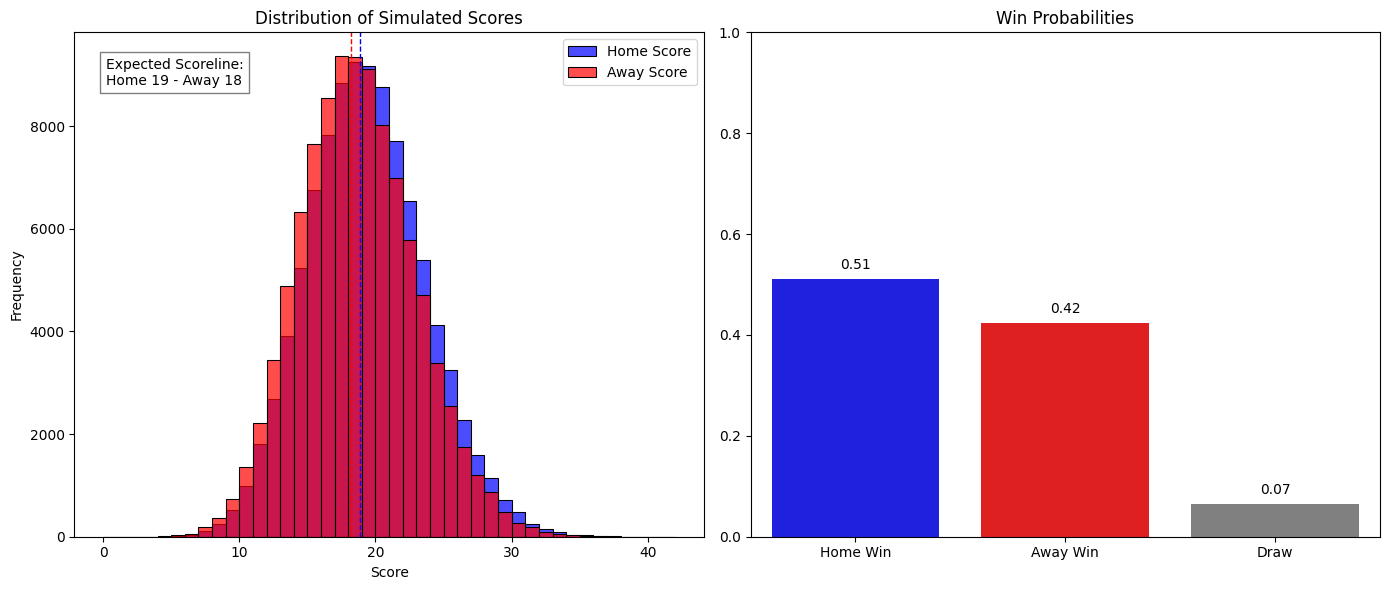

In [8]:
# Example usage with test_data
mp.plot_sampling_distributions(home_model, away_model, test_data, tc.predictors)

###  Evaluation
The evaluation phase involves predicting the outcomes of an unseen set of random NRL matches using the selected home and away models.

This section is only to be used in development and testing at the moment.
#### Classification Report

Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

    home_win       0.75      0.87      0.80       150
    away_win       0.78      0.63      0.70       115
        draw       0.00      0.00      0.00         0

   micro avg       0.76      0.76      0.76       265
   macro avg       0.51      0.50      0.50       265
weighted avg       0.76      0.76      0.76       265



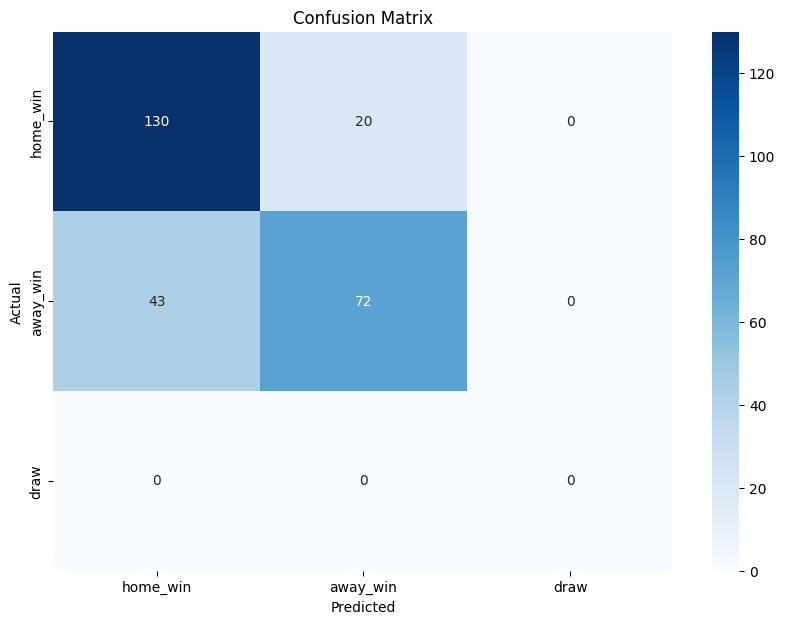

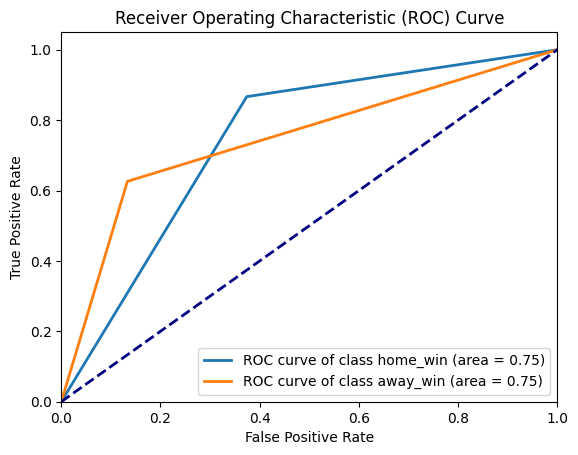

In [9]:
# Evaluate the models on the test data
result_df = mp.evaluate_models(home_model, away_model, test_data, tc.predictors)

#### Expected Scores

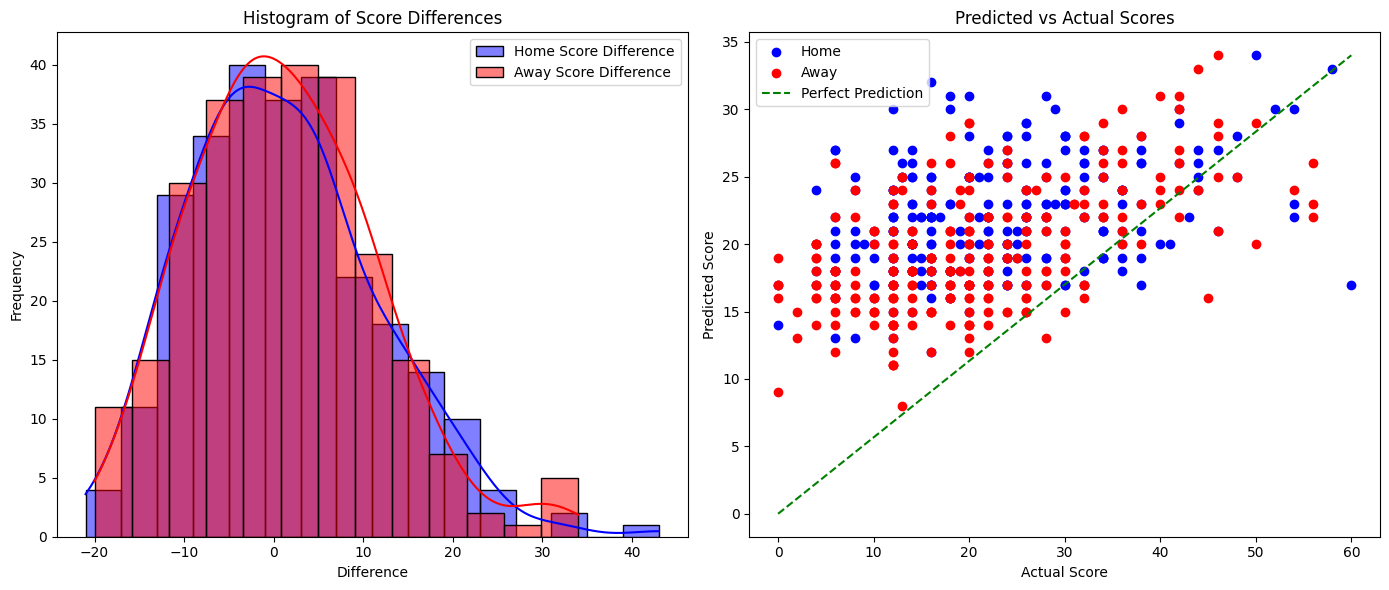

{'mae_home': 8.381132075471697,
 'mae_away': 8.135849056603774,
 'rmse_home': 10.566054582196813,
 'rmse_away': 10.29269753959133,
 'r2_home': 0.1286628551715583,
 'r2_away': 0.2659468095330093}

In [10]:
mp.evaluate_score_predictions(result_df)

## Save Models
The `save_models` function stores Pipeline objects to the disk. This allows for easy retrieval and reuse in future model prediction tasks, without the need to retrain these components. The objects are stored in a designated 'models' directory under the project root path, ensuring organized and consistent storage.

In [11]:
mf.save_models(home_model, 'home_model', project_root)
mf.save_models(away_model, 'away_model', project_root)

Pipeline saved to models/home_model.pkl
Pipeline saved to models/away_model.pkl


## Match Simulation and Prediction
The final stage of the pipeline involves predicting the outcomes of the current week's NRL matches. This is achieved by loading the saved models from the 'models' directory and utilizing them to simulate the matches. The predictions are then stored in a DataFrame, which is subsequently written back to the SQLite database. This data can be accessed by the front-end application to display the predicted outcomes to the users.

In [12]:
# Load the models
home_model = pf.load_models('home_model', project_root)
away_model = pf.load_models('away_model', project_root)

# Load this week's game data
inference_data = pf.get_inference_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/inference_data.sql')
inference_data

home_model model pipeline loaded
away_model model pipeline loaded
Getting inference data...


,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.024111e+10,20.0,Round 20,1.0,Pre Game,1.721419e+09,1.721383e+09,GIO Stadium,Canberra,None,...,1.0,-5.0,1466.742144,1490.804290,-24.062145,0.453863,0.513208,0.032929,-0.059345,1.344333
1,2.024111e+10,20.0,Round 20,2.0,Pre Game,1.721488e+09,1.721452e+09,Industree Group Stadium,Gosford,None,...,52.0,-38.0,1493.768531,1441.920648,51.847883,0.567919,0.414840,0.017241,0.153079,10.441167
2,2.024111e+10,20.0,Round 20,3.0,Pre Game,1.721497e+09,1.721461e+09,McDonald Jones Stadium,Newcastle,None,...,16.0,-8.0,1476.159867,1496.484108,-20.324241,0.459049,0.508022,0.032929,-0.048974,0.119033
3,2.024111e+10,20.0,Round 20,4.0,Pre Game,1.721504e+09,1.721468e+09,AAMI Park,Melbourne,None,...,-10.0,20.0,1526.670571,1559.707999,-33.037428,0.441441,0.525630,0.032929,-0.084189,4.270667
4,2.024111e+10,20.0,Round 20,5.0,Pre Game,1.721570e+09,1.721534e+09,BlueBet Stadium,Penrith,None,...,20.0,-30.0,1529.179128,1499.925850,29.253279,0.531011,0.441758,0.027231,0.089254,12.879433
5,2.024111e+10,20.0,Round 20,6.0,Pre Game,1.721578e+09,1.721542e+09,4 Pines Park,Sydney,None,...,-4.0,42.0,1521.779247,1496.042928,25.736320,0.526125,0.446644,0.027231,0.079481,7.557700
6,2.024111e+10,20.0,Round 20,7.0,Pre Game,1.721586e+09,1.721550e+09,Queensland Country Bank Stadium,Townsville,None,...,18.0,-19.0,1501.841680,1509.245624,-7.403943,0.477976,0.491055,0.030969,-0.013078,4.347300


### Prediction Simulation
The `simulate_predictions` function is used to predict the outcomes of the current week's NRL matches. It loads the saved models from the 'models' directory and uses them to simulate the matches. The predictions are then stored in a DataFrame, which is written back to the SQLite database.

In [13]:
import pandas as pd

# Predict match outcomes and scorelines for the inference data
outcomes, margins = pf.predict_match_outcome_and_scoreline(home_model, away_model, inference_data, tc.predictors)
pd.merge(outcomes, margins, on='game_id')

# Save the predictions to the database
pf.save_predictions_to_db(
    outcomes, 
    project_root / "data" / "footy-tipper-db.sqlite", 
    project_root / 'pipeline/common/sql/create_table.sql', 
    project_root / 'pipeline/common/sql/insert_into_table.sql'
)

Saving predictions to database...


## Sending Predictions via Email using ChatGPT
In this section, we will use the OpenAI ChatGPT model to generate an email template for sending the predictions to the users. We will use the predictions generated in the previous section and the ChatGPT model to create a personalized email template for each user. The email template will contain the predicted outcomes of the NRL matches for the current week.

In [14]:
from dotenv import load_dotenv
from pipeline.common.model_prediciton import prediction_functions as pf
from pipeline.common.use_predictions import sending_functions as sf

# Now construct the relative path to your SQLite database
db_path = project_root / "data" / "footy-tipper-db.sqlite"
secrets_path = project_root / "secrets.env"
json_path = project_root / "service-account-token.json"

load_dotenv(dotenv_path=secrets_path)

True

In [15]:
import sqlite3
import pandas as pd
# Connect to the SQLite database
con = sqlite3.connect(str(db_path))

# Read SQL query from external SQL file
with open(project_root / 'pipeline/common' / 'sql/prediction_table.sql', 'r') as file:
    query = file.read()

# Execute the query and fetch the results into a data frame
predictions = pd.read_sql_query(query, con)

# Disconnect from the SQLite database
con.close()

predictions

,game_id,home_team_result,team_home,position_home,team_head_to_head_odds_home,team_away,position_away,team_head_to_head_odds_away,home_team_win_prob,home_team_lose_prob,round_id,competition_year,round_name
0,20241112010,Win,Canberra Raiders,11,1.69,New Zealand Warriors,12,2.18,0.49073,0.44924,20,2024,Round 20
1,20241112020,Win,South Sydney Rabbitohs,15,1.32,Wests Tigers,17,3.41,0.96346,0.02581,20,2024,Round 20
2,20241112030,Loss,Newcastle Knights,10,2.36,Brisbane Broncos,13,1.60,0.44585,0.49115,20,2024,Round 20
3,20241112040,Loss,Melbourne Storm,1,2.10,Sydney Roosters,3,1.75,0.28337,0.66064,20,2024,Round 20
4,20241112050,Win,Penrith Panthers,2,1.21,Dolphins,6,4.45,0.94789,0.03690,20,2024,Round 20
5,20241112060,Win,Manly-Warringah Sea Eagles,7,1.45,Gold Coast Titans,14,2.78,0.74108,0.21238,20,2024,Round 20
6,20241112070,Win,North Queensland Cowboys,8,1.69,Canterbury-Bankstown Bulldogs,5,2.17,0.69075,0.25787,20,2024,Round 20


### Tippper Picks
The Tipper Picks are selcted games which show high value for the tipper to select. This is based on the predicted outcomes of the matches and the odds of the games.

This shows how predictions can be used to further enrich the user experience and provide valuable insights to the users.

In [16]:
tipper_picks = sf.get_tipper_picks(predictions)
tipper_picks

,team,price,price_min
1,South Sydney Rabbitohs,1.32,1.037926
4,Penrith Panthers,1.21,1.054975
5,Manly-Warringah Sea Eagles,1.45,1.349382
6,North Queensland Cowboys,1.69,1.447702
3,Sydney Roosters,1.75,1.513684


In [17]:
# sf.upload_df_to_drive(
#     predictions, 
#     json_path, 
#     os.getenv('FOLDER_ID'), 
#     "predictions.csv"
# )

### Reg Reagan's Email
In this section, we will generate an email from Reg Reagan, a fictional character, using the OpenAI ChatGPT model. The email will contain the predicted outcomes of the NRL matches for the current week, along with some humorous and engaging content. The email will be sent to the users to provide them with the predictions and entertain them at the same time.

In [18]:
reg_reagan = sf.generate_reg_regan_email(
    predictions, 
    tipper_picks, 
    os.getenv('OPENAI_KEY'), 
    os.getenv('FOLDER_URL'),
    1
)

print(reg_reagan)

Subject: Reg Reagan's Round 20 NRL Forecast and Stingy Tips for Punters 

G'day Lads, 

The old Footy Tipper was fed some footy data and it's spat out some juicy predictions for Round 20.

Apparently, in a surprising turn of events, the Canberra Raiders are bound to teach the Kiwis a lesson, even though they're 11th and 12th on the ladder respectively. The Veterans are looking fit, reckon the lads have been hitting the pints and pies less these days.

In an apparent upset that no one saw coming, except this genius Footy Tipper, the Bunnies will drop the blow on West's Tigers. I could've been reading the seasons wrong for decades, turns out winter is actually the Rabbitohs season.

Seems like the Knights are in for a round of humility, tipped to lose against the Broncos. Now, don't let the positions fool you, a horse is always fast on its home turf. Personally, I was hoping to see our Knights charging in glory, but well... it's football.

The Tipper has quite audaciously predicted a los

In [19]:
# sf.send_emails(
#     "footy-tipper-email-list", 
#     f"Footy Tipper Predictions for {predictions['round_name'].unique()[0]}", 
#     reg_reagan, 
#     os.getenv('MY_EMAIL'), 
#     os.getenv('EMAIL_PASSWORD'), 
#     json_path
# )